# 보스턴 집값 예측
---

In [1]:
from pandas import read_excel
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense
# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 학습에 대한 콜백함수 처리용 패키지 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# 표준화 처리 패키지
from sklearn.preprocessing import StandardScaler

# 회귀분석을 수행하는 통계 패키지 (머신러닝과는 연관 없음)
from statsmodels.formula.api import ols

# 보스턴 집값 데이터를 로드하기 위한 객체 참조
from sklearn import datasets

from sklearn.decomposition import PCA # 주성분 분석용 패키지
from pca import pca # 주성분 분석 결

## 데이터셋 준비하기
load_data()함수는 path로 지정된 파일을 검색해서 가져온다.

만약 지정된 파일이 없다면 패키지가 의미하는 데이터셋을 다운로드 받아 지정된 path에 저장한다.

In [2]:
dataset = datasets.load_boston()
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## 학습데이터(독립변수) 구조
- CRIM 자치시(town) 별 1인당 범죄율
- ZN 25,000 평방피트를 초과하는 거주지역의 비율
- INDUS 비소매상업지역이 점유하고 있는 토지의 비율
- CHAS 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX 10ppm 당 농축 일산화질소
- RM 주택 1가구당 평균 방의 개수
- AGE 1940년 이전에 건축된 소유주택의 비율
- DIS 5개의 보스턴 직업센터까지의 접근성 지수
- RAD 방사형 도로까지의 접근성 지수
- TAX 10,000 달러 당 재산세율
- PTRATIO 자치시(town)별 학생/교사 비율
- B 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함.
- LSTAT 모집단의 하위계층의 비율(%)

In [3]:
boston_df = DataFrame(dataset.data, columns=dataset.feature_names)
boston_df['MEDV'] = dataset.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [4]:
# 데이터의 전체 크기 확인
boston_df.shape

(506, 14)

In [5]:
# 각 변수들의 정보 조회
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [6]:
# 기초 통계량 확인
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
# 결측치 여부 확인
boston_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

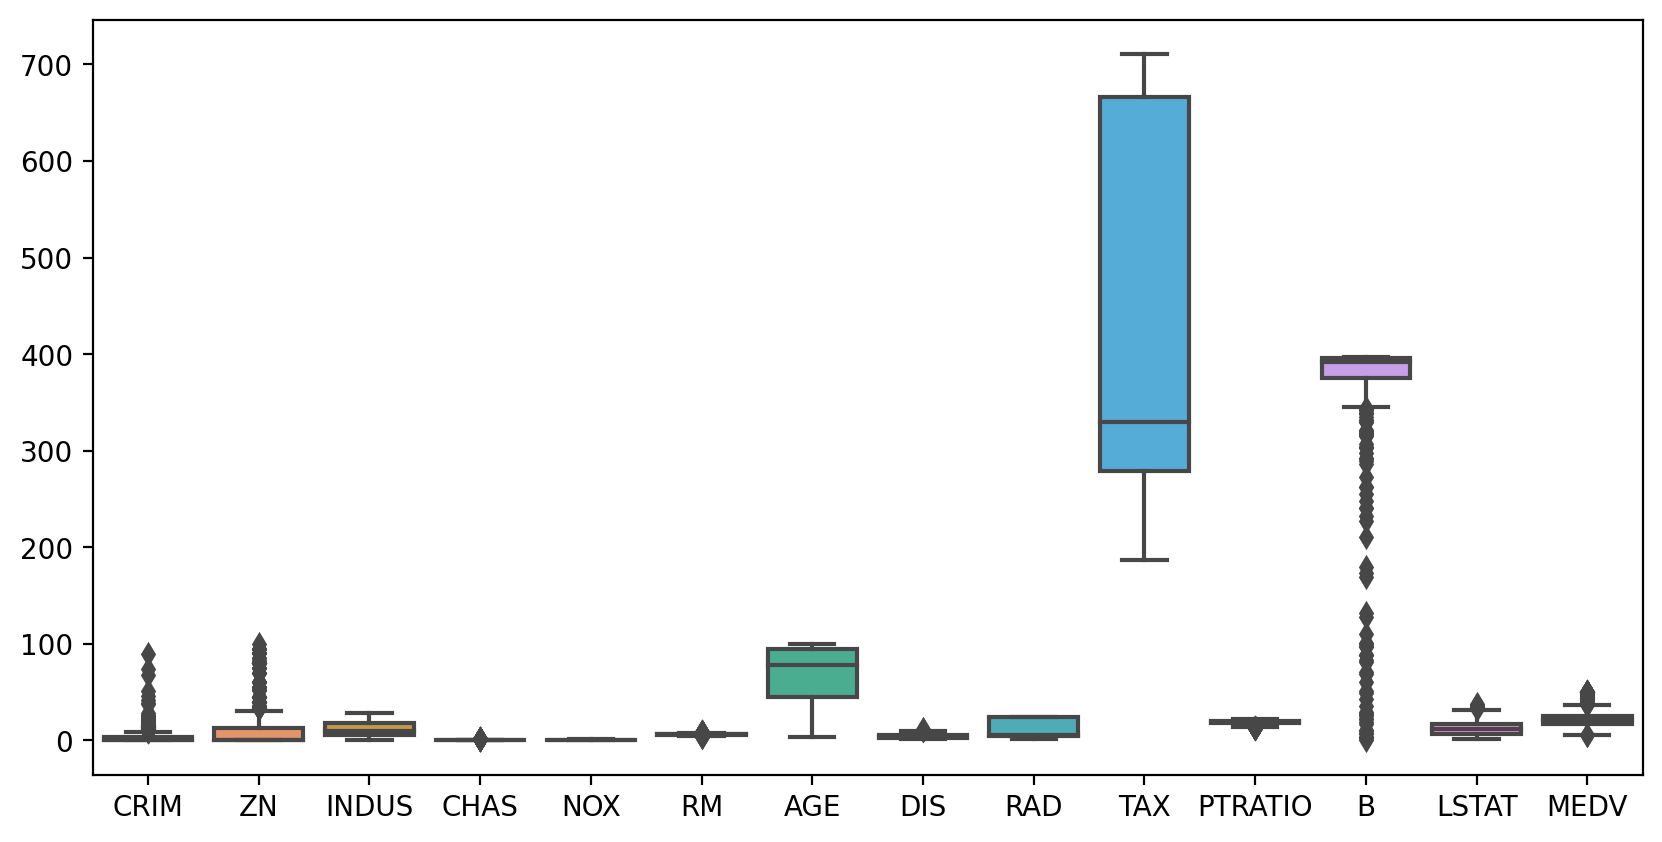

In [8]:
# 이상치 존재 여부 확인
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
sns.boxplot(data=boston_df, ax=ax)
plt.show()
plt.close()

In [9]:
# 독립변수들만 모여 있는 데이터프레임 정의
x_train_set = boston_df.drop('MEDV', axis=1)
# 종속변수만 있는 데이터프레임 정의
y_train_set = boston_df.filter(['MEDV'])

print(len(x_train_set), "/", len(y_train_set))

506 / 506


In [10]:
# 학습데이터와 검증데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(x_train_set, y_train_set, test_size=0.33, random_state=777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train), len(x_test)))

훈련용 데이터셋 크기: 339, 검증용 데이터셋 크기: 167


In [15]:
# 데이터 표준화
ss = StandardScaler()
std_x_train = DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
std_x_test = DataFrame(ss.transform(x_test), columns=x_test.columns)

## PCA(주성분) 분석을 통해 연관성 높은 변수들 찾기

In [16]:
model = pca(n_components=len(x_train.columns))
fit = model.fit_transform(std_x_train)
fit['topfeat']

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [13] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[13]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


,PC,feature,loading,type
0,PC1,NOX,0.352372,best
1,PC2,CHAS,0.554203,best
2,PC3,RM,0.538634,best
3,PC4,CHAS,0.676004,best
4,PC5,B,-0.770950,best
5,PC6,PTRATIO,-0.610748,best
6,PC7,CRIM,0.725569,best
7,PC8,AGE,-0.574541,best
8,PC9,INDUS,0.765635,best
9,PC10,LSTAT,-0.668250,best


In [17]:
pca_x_train = std_x_train.drop(['ZN','RAD'], axis=1)
pca_x_test = std_x_test.drop(['ZN','RAD'], axis=1)

In [18]:
# 데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.
model = Sequential()
# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (13, )))
model.add(Dense(32, activation = 'relu'))
# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함.
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [19]:
result = model.fit(std_x_train, y_train, epochs = 500, validation_data = (std_x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath = 'bostun_housing.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
])
result.history.keys()

Epoch 1/500
11/11 [==============================] - 0s 14ms/step - loss: 576.4349 - mae: 22.1674 - val_loss: 563.4392 - val_mae: 21.7635

Epoch 00001: val_loss improved from inf to 563.43921, saving model to bostun_housing.h5
Epoch 2/500
11/11 [==============================] - 0s 3ms/step - loss: 544.0556 - mae: 21.4379 - val_loss: 531.0176 - val_mae: 20.9827

Epoch 00002: val_loss improved from 563.43921 to 531.01764, saving model to bostun_housing.h5
Epoch 3/500
11/11 [==============================] - 0s 2ms/step - loss: 508.6271 - mae: 20.5850 - val_loss: 491.1470 - val_mae: 19.9828

Epoch 00003: val_loss improved from 531.01764 to 491.14697, saving model to bostun_housing.h5
Epoch 4/500
11/11 [==============================] - 0s 3ms/step - loss: 463.4856 - mae: 19.4432 - val_loss: 440.1643 - val_mae: 18.6454

Epoch 00004: val_loss improved from 491.14697 to 440.16431, saving model to bostun_housing.h5
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 406.

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

In [21]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,576.434937,22.167406,563.439209,21.763494,0.001000
2,544.055603,21.437937,531.017639,20.982679,0.001000
3,508.627106,20.584953,491.146973,19.982813,0.001000
4,463.485626,19.443193,440.164307,18.645382,0.001000
5,406.867798,17.962477,377.000977,16.898489,0.001000
...,...,...,...,...,...
106,7.071146,1.934357,20.686666,3.151616,0.000250
107,7.062215,1.933862,20.664354,3.151805,0.000250
108,7.047474,1.933356,20.613663,3.144796,0.000250


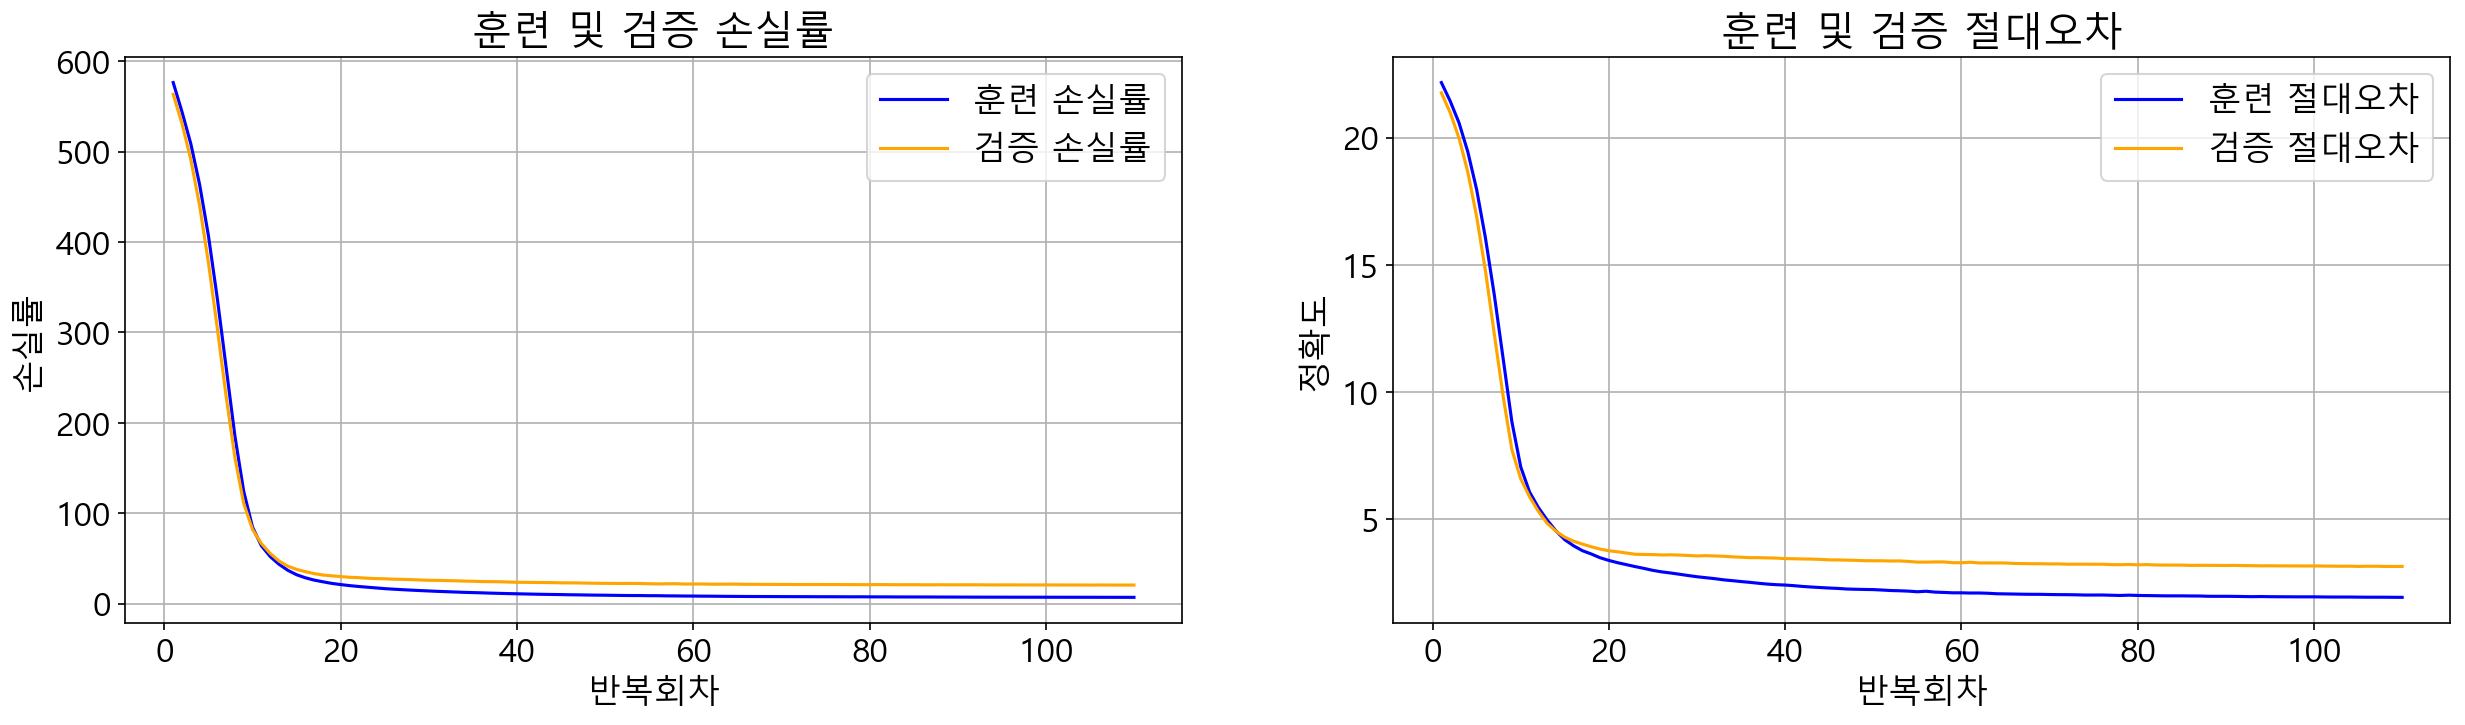

In [22]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sns.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [23]:
evaluate = model.evaluate(x_test, y_test)
print("최종 손실률: %f, 최종 절대오차: %f" % (evaluate[0], evaluate[1]))

6/6 [==============================] - 0s 1ms/step - loss: 6279562.5000 - mae: 2478.2561
최종 손실률: 6279562.500000, 최종 절대오차: 2478.256104


In [24]:
# 검증 데이터를 활용하여 dist 예측하기
test_predictions = model.predict(std_x_test)
test_predictions

array([[17.44795  ],
       [10.873777 ],
       [12.470183 ],
       [22.08436  ],
       [31.454483 ],
       [18.758492 ],
       [18.119043 ],
       [44.33496  ],
       [12.806325 ],
       [45.81219  ],
       [28.30346  ],
       [24.503588 ],
       [10.460991 ],
       [22.796997 ],
       [15.844858 ],
       [33.970398 ],
       [ 5.9967003],
       [20.281368 ],
       [23.788082 ],
       [15.732808 ],
       [17.022837 ],
       [18.94468  ],
       [ 9.673023 ],
       [25.021172 ],
       [14.150682 ],
       [26.068779 ],
       [25.348312 ],
       [32.306046 ],
       [20.594994 ],
       [22.047987 ],
       [26.469555 ],
       [27.7588   ],
       [24.839258 ],
       [27.35163  ],
       [26.640629 ],
       [27.947157 ],
       [12.101769 ],
       [26.596134 ],
       [16.081964 ],
       [17.70652  ],
       [23.382435 ],
       [15.619465 ],
       [12.137302 ],
       [15.859405 ],
       [14.373127 ],
       [21.962656 ],
       [ 8.831165 ],
       [22.45

In [25]:
# 2차 배열의 원소들을 1차 배열로 재배치
test_pred_flatten = test_predictions.flatten()
test_pred_flatten

array([17.44795  , 10.873777 , 12.470183 , 22.08436  , 31.454483 ,
       18.758492 , 18.119043 , 44.33496  , 12.806325 , 45.81219  ,
       28.30346  , 24.503588 , 10.460991 , 22.796997 , 15.844858 ,
       33.970398 ,  5.9967003, 20.281368 , 23.788082 , 15.732808 ,
       17.022837 , 18.94468  ,  9.673023 , 25.021172 , 14.150682 ,
       26.068779 , 25.348312 , 32.306046 , 20.594994 , 22.047987 ,
       26.469555 , 27.7588   , 24.839258 , 27.35163  , 26.640629 ,
       27.947157 , 12.101769 , 26.596134 , 16.081964 , 17.70652  ,
       23.382435 , 15.619465 , 12.137302 , 15.859405 , 14.373127 ,
       21.962656 ,  8.831165 , 22.45633  , 14.419731 , 18.846478 ,
       33.825363 , 37.24144  , 17.693184 , 17.849424 , 16.730057 ,
       19.743925 , 20.603693 , 14.230806 , 28.166122 , 14.911724 ,
       25.48173  , 19.957256 , 24.653965 , 12.807362 , 23.058422 ,
       34.510155 , 39.078552 , 18.56132  , 27.336954 , 15.203413 ,
       17.21068  , 12.1660385, 15.496371 , 19.636654 , 13.8987

In [26]:
y_test['MEDV'].values

array([22.5,  8.3, 17.2, 25. , 28.5, 23. , 18.9, 50. , 15.6, 38.7, 24.6,
       23.3,  9.5, 20. , 18.3, 36.4,  5. , 19.4, 28.1, 17.8, 19.6, 24.5,
       10.4, 23.7, 19.4, 23.9, 21.4, 29.9, 24.4, 23.1, 25. , 30.1, 22.8,
       22.8, 22. , 24.8, 15.6, 22. , 19.6, 13.1, 22.5, 18.9, 14.6, 13.3,
       17.4, 20.8, 10.8, 21.4, 17.2, 13.8, 28.7, 35.1, 10.2, 21.7, 20.5,
       25. , 21.1, 15.6, 23.6, 23.2, 28.7, 16.6, 26.2,  9.6, 18.2, 31.7,
       42.8, 16.1, 22.6, 18.1, 23.8, 11.8, 16. , 21.5, 13.9, 11.7, 44.8,
       20.1, 50. , 22.1, 20.6, 14.6, 48.8, 22.9, 14.4, 23.9, 15.6, 19.9,
       20.5,  8.7, 26.5, 20.3, 23.8, 44. , 18.5, 17.5, 22.8, 14.3, 10.9,
       36.1, 25. , 17.9, 17.7, 35.2, 20. , 24.3, 32.9, 15. , 50. , 33.8,
       21.9, 28.4, 10.2, 12. , 17.1, 17.1, 22. , 25.1, 20.9, 37.6, 15.6,
       43.5, 17.8, 20. , 15.2, 21.1, 19.9, 22.6, 14.4, 13.8, 37.3, 12.5,
       11.7, 26.6,  7.2, 18.6, 29. , 14.9, 14.2, 20.5, 19. , 50. , 27.1,
       18.4, 20.7, 29.6, 35.4, 21.7, 43.8, 22.6, 19

In [27]:
result_df = x_test.copy()
result_df['실제값'] = y_test['MEDV'].values
result_df['예측값'] = test_pred_flatten
result_df['예측오차'] = result_df['실제값']-result_df['예측값']
result_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,실제값,예측값,예측오차
207,0.25199,0.0,10.59,0.0,0.489,5.783,72.7,4.3549,4.0,277.0,18.6,389.43,18.06,22.5,17.447950,5.052050
425,15.86030,0.0,18.10,0.0,0.679,5.896,95.4,1.9096,24.0,666.0,20.2,7.68,24.39,8.3,10.873777,-2.573777
408,7.40389,0.0,18.10,0.0,0.597,5.617,97.9,1.4547,24.0,666.0,20.2,314.64,26.40,17.2,12.470183,4.729817
63,0.12650,25.0,5.13,0.0,0.453,6.762,43.4,7.9809,8.0,284.0,19.7,395.58,9.50,25.0,22.084360,2.915640
290,0.03502,80.0,4.95,0.0,0.411,6.861,27.9,5.1167,4.0,245.0,19.2,396.90,3.33,28.5,31.454483,-2.954483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.16760,0.0,7.38,0.0,0.493,6.426,52.3,4.5404,5.0,287.0,19.6,396.90,7.20,23.8,23.163761,0.636239
364,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9,47.292538,-25.392538
480,5.82401,0.0,18.10,0.0,0.532,6.242,64.7,3.4242,24.0,666.0,20.2,396.90,10.74,23.0,24.303499,-1.303499
152,1.12658,0.0,19.58,1.0,0.871,5.012,88.0,1.6102,5.0,403.0,14.7,343.28,12.12,15.3,16.487091,-1.187091


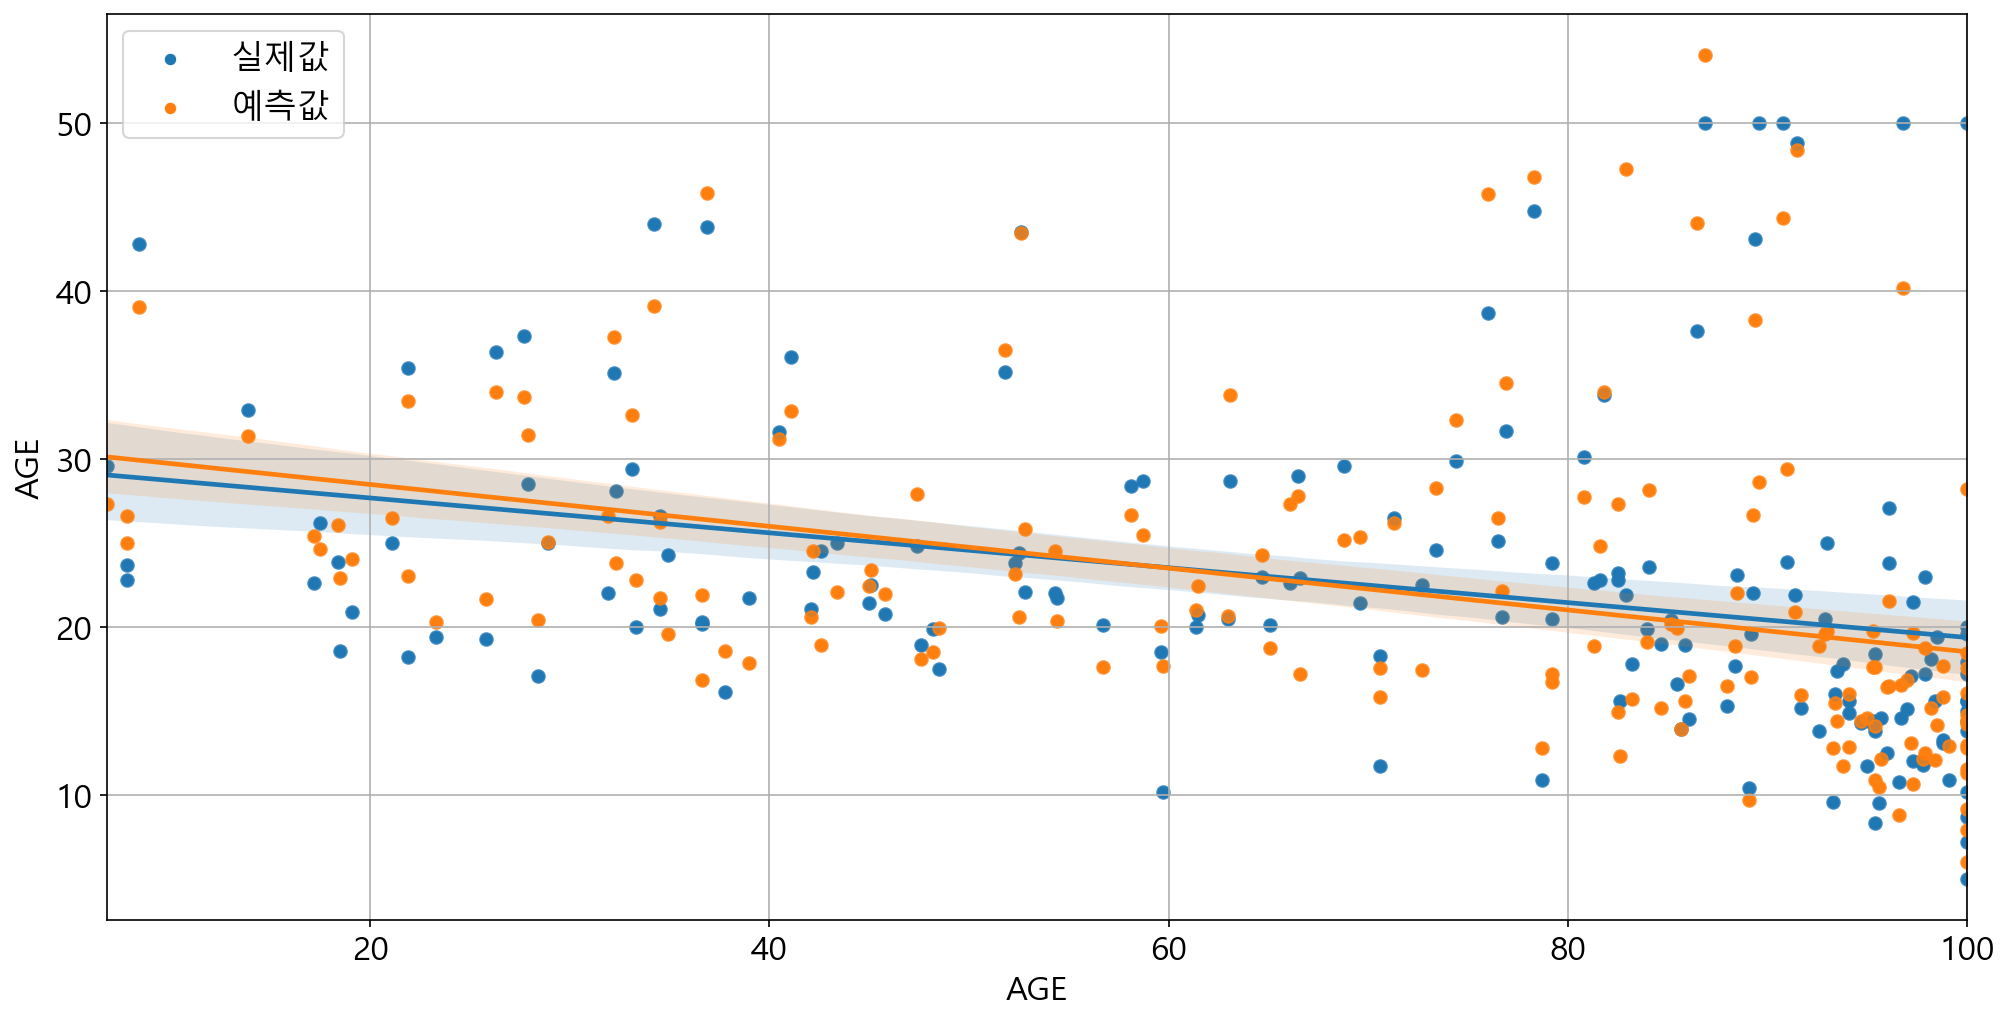

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=150)
sns.scatterplot(x='AGE', y='실제값', data=result_df, label='실제값')
sns.scatterplot(x='AGE', y='예측값', data=result_df, label='예측값')
sns.regplot(x='AGE', y='실제값', data=result_df)
sns.regplot(x='AGE', y='예측값', data=result_df)
ax.set_xlabel('AGE')
ax.set_ylabel('AGE')
ax.legend()
ax.grid()

plt.show()
plt.close()

In [29]:
result_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,실제값,예측값,예측오차
207,0.25199,0.0,10.59,0.0,0.489,5.783,72.7,4.3549,4.0,277.0,18.6,389.43,18.06,22.5,17.447950,5.052050
425,15.86030,0.0,18.10,0.0,0.679,5.896,95.4,1.9096,24.0,666.0,20.2,7.68,24.39,8.3,10.873777,-2.573777
408,7.40389,0.0,18.10,0.0,0.597,5.617,97.9,1.4547,24.0,666.0,20.2,314.64,26.40,17.2,12.470183,4.729817
63,0.12650,25.0,5.13,0.0,0.453,6.762,43.4,7.9809,8.0,284.0,19.7,395.58,9.50,25.0,22.084360,2.915640
290,0.03502,80.0,4.95,0.0,0.411,6.861,27.9,5.1167,4.0,245.0,19.2,396.90,3.33,28.5,31.454483,-2.954483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.16760,0.0,7.38,0.0,0.493,6.426,52.3,4.5404,5.0,287.0,19.6,396.90,7.20,23.8,23.163761,0.636239
364,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9,47.292538,-25.392538
480,5.82401,0.0,18.10,0.0,0.532,6.242,64.7,3.4242,24.0,666.0,20.2,396.90,10.74,23.0,24.303499,-1.303499
152,1.12658,0.0,19.58,1.0,0.871,5.012,88.0,1.6102,5.0,403.0,14.7,343.28,12.12,15.3,16.487091,-1.187091
